# Introduction

This is a demo of real-time data drift monitoring using Evidently. In this demo, we will train a Random Forest Regressor to predict house prices and simulate data drift by sending drifted feature(s) to the model as inputs.

Imagine we have a website for listing houses for sale, and we have a model to predict a house price based on the features of the house. The model is used in real-time, which means every time a user creates a new listing, the model gets queried for a prediction.

Because we don’t actually have a house listing website, we’ll be using a dataset from Kaggle and artifically skews the data distribution to simulate a scenario which data drift is present.

# Pre-requistes

This notebook assumes you have already **completed** step 1 to step 4 (setting up a virtual environment and installing the requirements) explained in the repo's README.md.

If we have done all the steps above correctly, right now our terminal should be in the new virtual environment we just created but not our notebook, we need to add our environment into Jupyter and select it as the Kernel we want to use.

Input the following command into your terminal:

`
pip install ipykernel
python -m ipykernel install --user --name=demoenv
`

Refresh the notebook and select the kernel. Under the *Kernel* tab on top of the notebook, hover onto *Change Kernel* and select the kernel named *demoenv*.

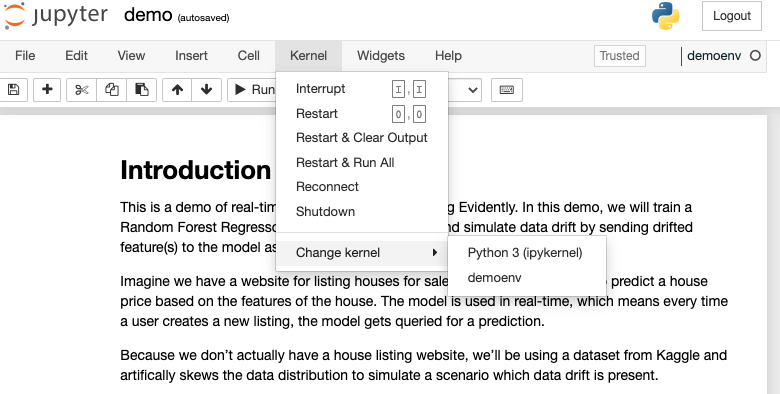

# 1. Setting up Kaggle

If you already have a Kaggle API token setup on your machine, you can skip step 1 and go to [step 2](#Step2). Otherwise, follow the steps below to set up Kaggle.

Before we can call `get_data.py` to download our dataset, we will need to log in or create a [Kaggle](https://www.kaggle.com/) account to generate an Kaggle API token.

Steps to download and set up the token:
- Go to account setting page.
- Under the API section, click create a new API token.
- The token will be downloaded as a .json file.
- Move the downloaded kaggle.json file into kaggle's folder using the following command in your terminal:

`mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json`

or 

- We can export them into the environment:

`export set KAGGLE_USERNAME=<your-kaggle-username>
export set KAGGLE_KEY=<your-kaggle-api-key>`

# 2. Downloading the dataset <a id="Step2"></a>

Within the data folder, we can find two scripts, the `get_data.py` for downloading the dataset from Kaggle and the `generate_dataset_for_demo.py` script for splitting the data into reference and production dataset.

In your terminal, input the following command:

In [1]:
%run -i "data/get_data.py"

2022-10-05 14:42:52,664 [INFO] Authenticating API keys
2022-10-05 14:42:52,667 [INFO] Keys authenticated
2022-10-05 14:42:52,668 [INFO] Downloading house pricing data from Kaggle


2022-10-05 14:42:53,317 [INFO] Extracting dataset zip file
2022-10-05 14:42:53,348 [INFO] Processing data
2022-10-05 14:42:53,516 [INFO] processed_house_data.csv generated


# 3. Splitting the data

Now we have our dataset stored in the `data` folder, the next step is to split it into production and reference dataset. 2 production dataset will be generated, one with a data distribution approximately the same as the reference dataset (no drift) and another production dataset with skewed distribtuion (drifted). To do this we can call the `generate_dataset_for_demo.py` script within our `data` folder.

In [2]:
%run -i "data/generate_dataset_for_demo.py"

2022-10-05 14:42:54,623 [INFO] Kaggle dataset loaded


{3: 0.492, 2: 0.114, 4: 0.305, 5: 0.069, 1: 0.007, 6: 0.011, 7: 0.001, 0: 0.001}
[0, 0, 0, 0, 0, 0, 1.0, 0]
{3: 0.613, 5: 0.098, 4: 0.28, 1: 0.003, 2: 0.006}
[0, 0, 0, 1.0, 0]


2022-10-05 14:42:55,065 [INFO] Reference and 2 scenarios production data are generated


# 4. Visualising the production datasets

For simplicity, we will only use two features from our dataset.

- "bedrooms": a numerical feature represents the number of bedrooms that the house have in the house sale.

- "condition": a categorical feature ranges from 1 to 5 with 5 being the best.

To get a better understanding on how the 2 production dataset different to each other, we can also plot the distribution using a histogram.

In [3]:
import os
import logging
import subprocess
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
prod_data_drift_path = "datasets/house_price_random_forest/production_with_drift.csv"
prod_data_no_drift_path = "datasets/house_price_random_forest/production_no_drift.csv"
ref_data_path = "datasets/house_price_random_forest/reference.csv"

In [5]:
prod_data_drift = pd.read_csv(prod_data_drift_path)
prod_data_no_drift = pd.read_csv(prod_data_no_drift_path)
ref_data = pd.read_csv(ref_data_path)

In [6]:
ref_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,price
0,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1955,221900.0
1,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,1951,538000.0
2,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,1933,180000.0
3,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1965,604000.0
4,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1987,510000.0


In [7]:
features = ['bedrooms', 'condition']

normal_bedrooms_dist = prod_data_no_drift[features[0]].to_list()
drifted_bedrooms_dist = prod_data_drift[features[0]].to_list()
ref_data_bedrooms_dist = ref_data[features[0]].to_list()

normal_condition_dist = prod_data_no_drift[features[1]].to_list()
drifted_condition_dist = prod_data_drift[features[1]].to_list()
ref_data_condition_dist = ref_data[features[1]].to_list()

(array([  0.,   4.,   6., 631., 257., 102.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

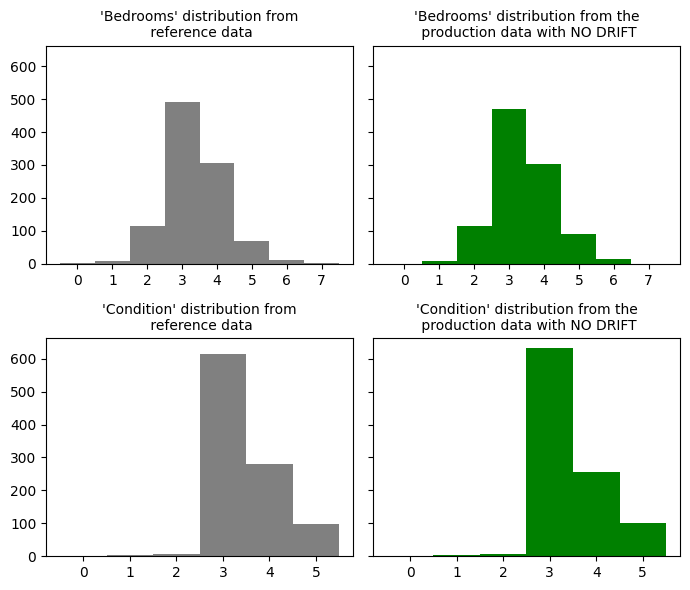

In [8]:
# Histogram comparison

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(7,6))

# Bedrooms Subplots

axs[0, 0].set_xticks(np.arange(9))
axs[0, 1].set_xticks(np.arange(9))

axs[0, 0].set_title("'Bedrooms' distribution from\n reference data", size=10)
axs[0, 1].set_title("'Bedrooms' distribution from the\n production data with NO DRIFT", size=10)

# Condition Subplots

axs[1, 0].set_xticks(np.arange(7))
axs[1, 1].set_xticks(np.arange(7))

axs[1, 0].set_title("'Condition' distribution from\n reference data", size=10)
axs[1, 1].set_title("'Condition' distribution from the\n production data with NO DRIFT", size=10)

axs[0, 0].hist(ref_data_bedrooms_dist, bins=np.arange(9)-0.5, color='gray')
axs[0, 1].hist(normal_bedrooms_dist, bins=np.arange(9)-0.5, color='green')
axs[1, 0].hist(ref_data_condition_dist, bins=np.arange(7)-0.5, color='gray')
axs[1, 1].hist(normal_condition_dist, bins=np.arange(7)-0.5, color='green')

The histogram above shows the distribution of the number of bedrooms and the house conditions in the reference dataset and the production dataset with no drift, the distribution is almost identical, hence we will expect almost no data drift will be detected by Evidently.

The feature (bedrooms) distribution of the reference dataset is first computed to get the probability that represent how likely a certain number of bedrooms will appear in the reference dataset. E.g. From the plot above, we can see that 0 and 7 bedrooms has the lowest probability of being in the dataset.

(array([  0., 311.,   6., 454., 158.,  71.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

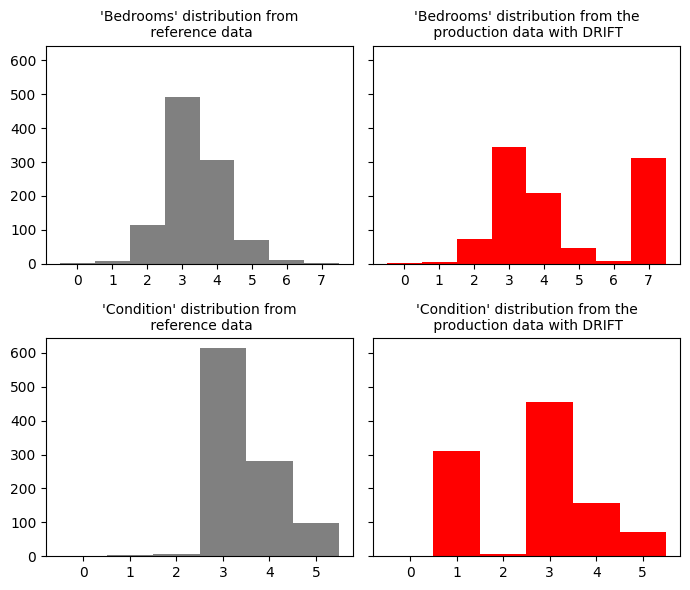

In [9]:
# Histogram comparison

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(7,6))

# Bedrooms Subplots

axs[0, 0].set_xticks(np.arange(9))
axs[0, 1].set_xticks(np.arange(9))

axs[0, 0].set_title("'Bedrooms' distribution from\n reference data", size=10)
axs[0, 1].set_title("'Bedrooms' distribution from the\n production data with DRIFT", size=10)

# Condition Subplots

axs[1, 0].set_xticks(np.arange(7))
axs[1, 1].set_xticks(np.arange(7))

axs[1, 0].set_title("'Condition' distribution from\n reference data", size=10)
axs[1, 1].set_title("'Condition' distribution from the\n production data with DRIFT", size=10)

axs[0, 0].hist(ref_data_bedrooms_dist, bins=np.arange(9)-0.5, color='gray')
axs[0, 1].hist(drifted_bedrooms_dist, bins=np.arange(9)-0.5, color='red')
axs[1, 0].hist(ref_data_condition_dist, bins=np.arange(7)-0.5, color='gray')
axs[1, 1].hist(drifted_condition_dist, bins=np.arange(7)-0.5, color='red')

Looking at the histogram for the drifted dataset, the data distribution is skewed in a way such that the number of bedrooms that appeared the least in the reference dataset has a much higher appearance in the drfited dataset which result in data drift.

# Training the Random Forest Regressor

Once the model is trained, it will be saved as `model.pkl` inside the `models` folder.

In [10]:
%run -i "pipeline/train.py"

2022-10-05 14:43:16,671 [INFO] Preparing data for train and test
2022-10-05 14:43:16,676 [INFO] Creating Random Forest Regressor model
2022-10-05 14:43:16,677 [INFO] Training model
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
2022-10-05 14:43:16,916 [INFO] Training Completed
2022-10-05 14:43:16,917 [INFO] Evaluating model on test set
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
2022-10-05 14:43:16,931 [INFO] Mean Squared Error: 47334200414.82994
2022-10-05 14:43:16,931 [INFO] Mean Absolute Error: 135145.613275
2022-10-05 14:43:16,932 [INFO] Root Mean Squared Error: 217564.2443390686
2022-10-05 14:43:16,932 [INFO] R-Squared: 0.7006567106232879


# Running the demo

We now have everything ready and we can run the demo with docker compose.

In [16]:
def run_script(cmd: list, wait: bool) -> None:
    logging.info("Run %s", " ".join(cmd))
    script_process = subprocess.Popen(" ".join(cmd), stdout = subprocess.PIPE, shell = True)

    if wait:
        script_process.wait()

        if script_process.returncode != 0:
            exit(script_process.returncode)

            
def setup_logger() -> None:
    logging.basicConfig(
        level=logging.INFO, 
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[
            logging.StreamHandler()
        ]
    )

    
def run_docker_compose() -> None:
    '''
    Run all containers using docker compose.
    '''
    if os.system("docker image ls -q") != None:
        os.system("docker image rm $(docker image ls -q)")
    if os.system("docker volume ls -q") != None:
        os.system("docker volume rm $(docker volume ls -q)")
    logging.info("Running docker compose")
    run_script(cmd=["docker-compose", "up", "-d"], wait=True)

    
def stop_docker_compose() -> None:
    os.system("docker compose down")

# Scenario 1: No data drift

Run the cells below to call the no_data_drift_scenario() function.

In [29]:
def send_non_drifted_data_to_model_server() -> None:
    '''
    Send data with no drift to the model server for predictions.
    '''
    os.system("python3 scenarios/no_drift.py")

def no_data_drift_scenario():
    setup_logger()
    run_docker_compose()
    time.sleep(5)
    send_non_drifted_data_to_model_server()

In [30]:
no_data_drift_scenario()

f2a2252987d8
08b33606ac24
7ffd02567011
99169ddb2b0b
Untagged: prom/prometheus:latest
Untagged: prom/prometheus@sha256:1a70874024f82008d4f327921598dd6e9eb84460d27c13524c4fa0ee4b482012
Deleted: sha256:f2a2252987d856fb051c4e4c8215f935f0120d342ff22c986923f4453b0b36d5
Deleted: sha256:199330830226493425a20a3df3258d14e5ceb542c218c51301079664c554ae60
Deleted: sha256:1c2756b878694c4bd9b53fdc1c0ddfceffc5976bdd7558efc9f513291e766675
Deleted: sha256:d49954131700b4f896a89fabbc218472338b7ba4cdd6d57da29fe76f17e3e96a
Deleted: sha256:41b4d826207ba643d239ad777e9cd187cb76071e21bd9b795ea8e52a0e248b9e
Deleted: sha256:8f59ee65908e17705878f28d84f4fa2fb97aea46337e068e3f2e1c2bb5a2edd3
Deleted: sha256:23a8defbdcf9ffd647b8d3eb9c9fb21d79fc926d149c45b60675602f14c235a9
Deleted: sha256:5729e1bfaff7113e0f99dbb08d7af06f2eea4719e7bab63fc3d930f6317b0c9d
Deleted: sha256:9eaf69d97744f154c36e5e7396a5887b66df5e7d1cca89bd43af3a19a2ab8f54
Deleted: sha256:3508ecac172333d30fa13f3cf0d089d976ad39e08a8fe0557d86b32ea592daea
Deleted

2022-10-05 15:26:01,966 [INFO] Running docker compose
2022-10-05 15:26:01,967 [INFO] Run docker-compose up -d


evidently-monitoring-demo_grafana_data
evidently-monitoring-demo_prometheus_data


Creating network "evidently-monitoring-demo_back-tier" with the default driver
Creating network "evidently-monitoring-demo_front-tier" with the default driver
Creating volume "evidently-monitoring-demo_prometheus_data" with default driver
Creating volume "evidently-monitoring-demo_grafana_data" with default driver
Pulling prometheus (prom/prometheus:)...
Pulling grafana (grafana/grafana:)...
Building evidently_service
#1 [internal] load build definition from Dockerfile
#1 sha256:6fc317d5346deb01ebb7a977c6ae718f50c75329e02e9f1be26a1b50397089a2
#1 transferring dockerfile: 216B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 sha256:bc15cb66ef9b646d4519ecea8ed34cd290c4ab18aa3f07e1dc6a53a092a1d162
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.10-slim-buster
#3 sha256:c95b2648fd476c85c6c299e43896bc88174167326d543011e94dfb7470e4b74c
#3 DONE 1.2s

#4 [1/4] FROM docker.io/library/python:3.10-slim-buster@sha256:b90e005661896b388d

2022-10-05 15:27:22,843 [INFO] Sending a request
2022-10-05 15:27:22,886 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:24,891 [INFO] Sending a request
2022-10-05 15:27:24,930 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:26,935 [INFO] Sending a request
2022-10-05 15:27:26,962 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:28,968 [INFO] Sending a request
2022-10-05 15:27:29,012 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:31,014 [INFO] Sending a request
2022-10-05 15:27:31,058 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:33,062 [INFO] Sending a request
2022-10-05 15:27:33,109 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:35,111 [INFO] Sending a request
2022-10-05 15:27:35,158 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:37,163 [INFO] Sending a request
2022-10-05 15:27:37,216 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:27:39,217 [INFO] S

Wait for Docker-Compose to set up.

We should now see data from the non_drifted_dataset are being sent to the inference server row by row.

To monitor data drift, we can use our pre-built Grafana dashboard which can be access [here](http://localhost:3000/).

When the metrics are calculated by Evidently, they are logged to Prometheus. To access Prometheus web interface, click [here](http://localhost:9090/). 

To stop this scenario, we can pause the cell above and run the stop_docker_compose() function below to completely stop the demo.

### Important

Grafana might ask you to login with a username and password. The default username and password is "**admin**".

In [31]:
stop_docker_compose()

Container evidently-monitoring-demo_inference_service_1  Stopping
Container evidently-monitoring-demo_inference_service_1  Stopping
Container evidently-monitoring-demo_inference_service_1  Stopped
Container evidently-monitoring-demo_inference_service_1  Removing
Container evidently-monitoring-demo_inference_service_1  Removed
Container evidently-monitoring-demo_evidently_service_1  Stopping
Container evidently-monitoring-demo_evidently_service_1  Stopping
Container evidently-monitoring-demo_evidently_service_1  Stopped
Container evidently-monitoring-demo_evidently_service_1  Removing
Container evidently-monitoring-demo_evidently_service_1  Removed
Container evidently-monitoring-demo_grafana_1  Stopping
Container evidently-monitoring-demo_grafana_1  Stopping
Container evidently-monitoring-demo_grafana_1  Stopped
Container evidently-monitoring-demo_grafana_1  Removing
Container evidently-monitoring-demo_grafana_1  Removed
Container evidently-monitoring-demo_prometheus_1  Stopping
Contain

# Scenario 2: Data drift

In [32]:
def send_drifted_data_to_model_server() -> None:
    '''
    Send data with drift to the model server for predictions.
    '''
    os.system("python3 scenarios/drift.py")

def data_drift_scenario():
    setup_logger()
    run_docker_compose()
    time.sleep(5)
    send_drifted_data_to_model_server()

In [35]:
data_drift_scenario()

f2a2252987d8
08b33606ac24
7ffd02567011
99169ddb2b0b
Untagged: prom/prometheus:latest
Untagged: prom/prometheus@sha256:1a70874024f82008d4f327921598dd6e9eb84460d27c13524c4fa0ee4b482012
Deleted: sha256:f2a2252987d856fb051c4e4c8215f935f0120d342ff22c986923f4453b0b36d5
Deleted: sha256:199330830226493425a20a3df3258d14e5ceb542c218c51301079664c554ae60
Deleted: sha256:1c2756b878694c4bd9b53fdc1c0ddfceffc5976bdd7558efc9f513291e766675
Deleted: sha256:d49954131700b4f896a89fabbc218472338b7ba4cdd6d57da29fe76f17e3e96a
Deleted: sha256:41b4d826207ba643d239ad777e9cd187cb76071e21bd9b795ea8e52a0e248b9e
Deleted: sha256:8f59ee65908e17705878f28d84f4fa2fb97aea46337e068e3f2e1c2bb5a2edd3
Deleted: sha256:23a8defbdcf9ffd647b8d3eb9c9fb21d79fc926d149c45b60675602f14c235a9
Deleted: sha256:5729e1bfaff7113e0f99dbb08d7af06f2eea4719e7bab63fc3d930f6317b0c9d
Deleted: sha256:9eaf69d97744f154c36e5e7396a5887b66df5e7d1cca89bd43af3a19a2ab8f54
Deleted: sha256:3508ecac172333d30fa13f3cf0d089d976ad39e08a8fe0557d86b32ea592daea
Deleted

2022-10-05 15:30:56,224 [INFO] Running docker compose
2022-10-05 15:30:56,225 [INFO] Run docker-compose up -d


evidently-monitoring-demo_grafana_data
evidently-monitoring-demo_prometheus_data


Creating network "evidently-monitoring-demo_back-tier" with the default driver
Creating network "evidently-monitoring-demo_front-tier" with the default driver
Creating volume "evidently-monitoring-demo_prometheus_data" with default driver
Creating volume "evidently-monitoring-demo_grafana_data" with default driver
Pulling prometheus (prom/prometheus:)...
Pulling grafana (grafana/grafana:)...
Building evidently_service
#1 [internal] load build definition from Dockerfile
#1 sha256:2d22178c853ef3d29d4c2c521b4f7e127ba86629668aaf3e6f13a953f9b3348e
#1 transferring dockerfile: 216B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 sha256:082984eaeb43ef6eb916662d00e4ed4483b38871619968111d567f61ee70834d
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.10-slim-buster
#3 sha256:c95b2648fd476c85c6c299e43896bc88174167326d543011e94dfb7470e4b74c
#3 DONE 1.1s

#4 [1/4] FROM docker.io/library/python:3.10-slim-buster@sha256:b90e005661896b388d

2022-10-05 15:32:18,216 [INFO] Sending a request
2022-10-05 15:32:18,263 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:20,266 [INFO] Sending a request
2022-10-05 15:32:20,307 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:22,313 [INFO] Sending a request
2022-10-05 15:32:22,358 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:24,363 [INFO] Sending a request
2022-10-05 15:32:24,410 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:26,412 [INFO] Sending a request
2022-10-05 15:32:26,441 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:28,445 [INFO] Sending a request
2022-10-05 15:32:28,483 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:30,487 [INFO] Sending a request
2022-10-05 15:32:30,533 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:32,537 [INFO] Sending a request
2022-10-05 15:32:32,586 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:32:34,591 [INFO] S

2022-10-05 15:34:37,438 [INFO] Sending a request
2022-10-05 15:34:37,482 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:39,482 [INFO] Sending a request
2022-10-05 15:34:39,522 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:41,523 [INFO] Sending a request
2022-10-05 15:34:41,554 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:43,555 [INFO] Sending a request
2022-10-05 15:34:43,597 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:45,601 [INFO] Sending a request
2022-10-05 15:34:45,650 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:47,652 [INFO] Sending a request
2022-10-05 15:34:47,699 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:49,705 [INFO] Sending a request
2022-10-05 15:34:49,754 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:51,758 [INFO] Sending a request
2022-10-05 15:34:51,805 [INFO] Waiting for 2 seconds till next request.
2022-10-05 15:34:53,809 [INFO] S

To monitor data drift, we can use our pre-built Grafana dashboard which can be access [here](http://localhost:3000/).

When the metrics are calculated by Evidently, they are logged to Prometheus. To access Prometheus web interface, click [here](http://localhost:9090/)

To stop this scenario, we can pause the cell above and run the stop_docker_compose() function below to completely stop the demo.

In [36]:
stop_docker_compose()

Container evidently-monitoring-demo_inference_service_1  Stopping
Container evidently-monitoring-demo_inference_service_1  Stopping
Container evidently-monitoring-demo_inference_service_1  Stopped
Container evidently-monitoring-demo_inference_service_1  Removing
Container evidently-monitoring-demo_inference_service_1  Removed
Container evidently-monitoring-demo_evidently_service_1  Stopping
Container evidently-monitoring-demo_evidently_service_1  Stopping
Container evidently-monitoring-demo_evidently_service_1  Stopped
Container evidently-monitoring-demo_evidently_service_1  Removing
Container evidently-monitoring-demo_evidently_service_1  Removed
Container evidently-monitoring-demo_grafana_1  Stopping
Container evidently-monitoring-demo_grafana_1  Stopping
Container evidently-monitoring-demo_grafana_1  Stopped
Container evidently-monitoring-demo_grafana_1  Removing
Container evidently-monitoring-demo_grafana_1  Removed
Container evidently-monitoring-demo_prometheus_1  Stopping
Contain